In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn.preprocessing
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from keras.layers import Dense,Dropout,SimpleRNN,LSTM
from keras.models import Sequential

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [2]:
df = pd.read_csv('D:\\dataset\\hourly_forecast\\DOM_hourly.csv',index_col='Datetime', parse_dates=['Datetime'])

In [3]:
df

,DOM_MW
Datetime,
2005-12-31 01:00:00,9389.0
2005-12-31 02:00:00,9070.0
2005-12-31 03:00:00,9001.0
2005-12-31 04:00:00,9042.0
2005-12-31 05:00:00,9132.0
...,...
2018-01-01 20:00:00,18418.0
2018-01-01 21:00:00,18567.0
2018-01-01 22:00:00,18307.0


In [4]:
df['DOM_MW'].describe()

count    116189.000000
mean      10949.203625
std        2413.946569
min        1253.000000
25%        9322.000000
50%       10501.000000
75%       12378.000000
max       21651.000000
Name: DOM_MW, dtype: float64

In [5]:
#checking missing data
df.isna().sum()

DOM_MW    0
dtype: int64

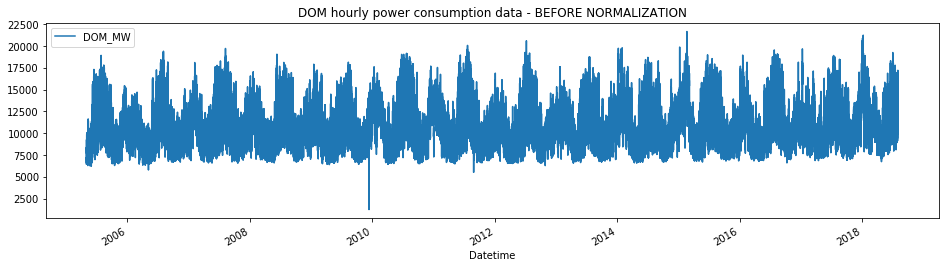

In [6]:
df.plot(figsize=(16,4),legend=True)

plt.title('DOM hourly power consumption data - BEFORE NORMALIZATION')

plt.show()

Normalize data

In [7]:
def norm_test(x):
    return (x-df['DOM_MW'].mean())/df['DOM_MW'].std()


In [8]:
df['DOM_MW']=norm_test(df['DOM_MW'])

In [9]:
df

,DOM_MW
Datetime,
2005-12-31 01:00:00,-0.646329
2005-12-31 02:00:00,-0.778478
2005-12-31 03:00:00,-0.807062
2005-12-31 04:00:00,-0.790077
2005-12-31 05:00:00,-0.752794
...,...
2018-01-01 20:00:00,3.094019
2018-01-01 21:00:00,3.155744
2018-01-01 22:00:00,3.048036


In [10]:
#def normalize_data(df):
#    scaler = sklearn.preprocessing.MinMaxScaler()
#    df['DOM_MW']=scaler.fit_transform(df['DOM_MW'].values.reshape(-1,1))
#    return df

#df = normalize_data(df)
#df.shape

Visualize data after normalization

In [11]:
#df.plot(figsize=(16,4),legend=True)

#plt.title('DOM hourly power consumption data - AFTER NORMALIZATION')

#plt.show()

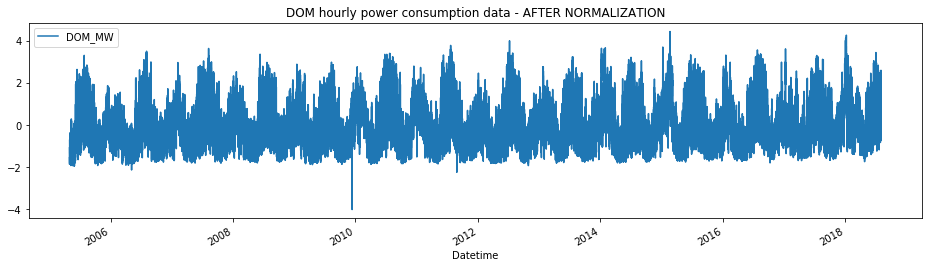

In [12]:
df.plot(figsize=(16,4),legend=True)

plt.title('DOM hourly power consumption data - AFTER NORMALIZATION')

plt.show()

Prepare data for training the RNN models

In [13]:
def load_data(stock, seq_len):
    X_train = []
    y_train = []
    for i in range(seq_len, len(stock)):
        X_train.append(stock.iloc[i-seq_len : i, 0])
        y_train.append(stock.iloc[i, 0])
    
    #1 last 6189 days are going to be used in test
    X_test = X_train[110000:]             
    y_test = y_train[110000:]

    #2 first 110000 days are going to be used in training
    X_train = X_train[:110000]           
    y_train = y_train[:110000]
    
    #3 convert to numpy array
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    #4 reshape data to input into RNN models
    X_train = np.reshape(X_train, (110000, seq_len, 1))
    
    X_test = np.reshape(X_test, (X_test.shape[0], seq_len, 1))
    
    return [X_train, y_train, X_test, y_test]

In [14]:
seq_len = 50 #choose sequence length

In [15]:
X_train, y_train, X_test, y_test = load_data(df, seq_len)

print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',y_test.shape)

X_train.shape =  (110000, 50, 1)
y_train.shape =  (110000,)
X_test.shape =  (6139, 50, 1)
y_test.shape =  (6139,)


In [16]:
rnn_model = Sequential()

rnn_model.add(SimpleRNN(40,activation='relu',return_sequences=True, input_shape=(X_train.shape[1],1)))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation='relu',return_sequences=True))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation='relu',return_sequences=False))
rnn_model.add(Dropout(0.15))

rnn_model.add(Dense(1))

rnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 50, 40)            1680      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 40)            0         
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 50, 40)            3240      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50, 40)            0         
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 40)                3240      
_________________________________________________________________
dropout_3 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [17]:
rnn_model.compile(optimizer="adam",loss="MSE")
hist_1 = rnn_model.fit(X_train, y_train, epochs=10, batch_size=1000, validation_split=0.2, shuffle=False)


Train on 88000 samples, validate on 22000 samples
Epoch 1/10
88000/88000 [==============================] - 18s 204us/step - loss: 0.2895 - val_loss: 0.0565
Epoch 2/10
88000/88000 [==============================] - 19s 211us/step - loss: 0.0931 - val_loss: 0.0403
Epoch 3/10
88000/88000 [==============================] - 20s 229us/step - loss: 0.0794 - val_loss: 0.0380
Epoch 4/10
88000/88000 [==============================] - 19s 215us/step - loss: 0.0661 - val_loss: 0.0319
Epoch 5/10
88000/88000 [==============================] - 18s 200us/step - loss: 0.0630 - val_loss: 0.0312
Epoch 6/10
88000/88000 [==============================] - 16s 177us/step - loss: 0.0581 - val_loss: 0.0315
Epoch 7/10
88000/88000 [==============================] - 16s 185us/step - loss: 0.0554 - val_loss: 0.0331
Epoch 8/10
88000/88000 [==============================] - 16s 184us/step - loss: 0.0522 - val_loss: 0.0316
Epoch 9/10
88000/88000 [==============================] - 16s 180us/step - loss: 0.0571 - val

Performance Evaluation

In [18]:
rnn_predictions = rnn_model.predict(X_test)

rnn_score = r2_score(y_test,rnn_predictions)
print("R2 Score of RNN model = ",rnn_score)

R2 Score of RNN model =  0.9546768719397035


In [19]:
rnn_train_pred = rnn_model.predict(X_train)
rnn_test_pred = rnn_model.predict(X_test)
print('Train rmse:', np.sqrt(mean_squared_error(y_train, rnn_train_pred)))
print('Test rmse:', np.sqrt(mean_squared_error(y_test, rnn_test_pred)))

Train rmse: 0.17673503324199488
Test rmse: 0.22148599879460676


Compare the actual values vs predicted values by plotting a graph

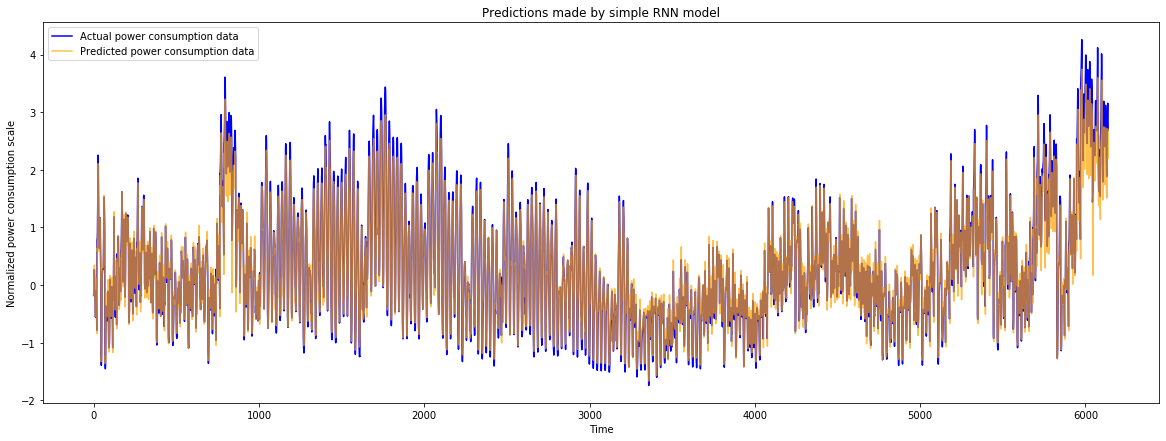

In [20]:
def plot_predictions(test, predicted, title):
    plt.figure(figsize=(20,7))
    plt.plot(test, color='blue',label='Actual power consumption data')
    plt.plot(predicted, alpha=0.7, color='orange',label='Predicted power consumption data')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Normalized power consumption scale')
    plt.legend()
    plt.show()
    
plot_predictions(y_test, rnn_predictions, "Predictions made by simple RNN model")

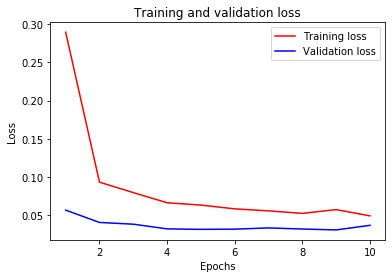

In [21]:
import matplotlib.pyplot as plt

loss = hist_1.history['loss']
val_loss = hist_1.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

LSTM model

In [22]:
lstm_model = Sequential()

lstm_model.add(LSTM(40,activation='tanh',return_sequences=True, input_shape=(X_train.shape[1],1)))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40,activation='tanh',return_sequences=True))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40,activation='tanh',return_sequences=False))
lstm_model.add(Dropout(0.15))

lstm_model.add(Dense(1))

lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50, 40)            6720      
_________________________________________________________________
dropout_4 (Dropout)          (None, 50, 40)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50, 40)            12960     
_________________________________________________________________
dropout_5 (Dropout)          (None, 50, 40)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 40)                12960     
_________________________________________________________________
dropout_6 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

In [23]:
lstm_model.compile(optimizer="adam",loss="MSE")
hist_2 = lstm_model.fit(X_train, y_train, epochs=10, batch_size=1000, validation_split=0.2, shuffle=False)

Train on 88000 samples, validate on 22000 samples
Epoch 1/10
88000/88000 [==============================] - 46s 520us/step - loss: 0.5012 - val_loss: 0.3236
Epoch 2/10
88000/88000 [==============================] - 44s 500us/step - loss: 0.2492 - val_loss: 0.2136
Epoch 3/10
88000/88000 [==============================] - 49s 554us/step - loss: 0.2013 - val_loss: 0.1965
Epoch 4/10
88000/88000 [==============================] - 45s 511us/step - loss: 0.1786 - val_loss: 0.1747
Epoch 5/10
88000/88000 [==============================] - 42s 474us/step - loss: 0.1663 - val_loss: 0.1571
Epoch 6/10
88000/88000 [==============================] - 56s 642us/step - loss: 0.1464 - val_loss: 0.1254
Epoch 7/10
88000/88000 [==============================] - 64s 723us/step - loss: 0.1213 - val_loss: 0.0858
Epoch 8/10
88000/88000 [==============================] - 57s 646us/step - loss: 0.0991 - val_loss: 0.0554
Epoch 9/10
88000/88000 [==============================] - 55s 627us/step - loss: 0.0688 - val_

In [24]:
lstm_predictions = lstm_model.predict(X_test)

lstm_score = r2_score(y_test, lstm_predictions)
print("R^2 Score of LSTM model = ",lstm_score)

R^2 Score of LSTM model =  0.9544318753578025


In [25]:
lstm_train_pred = lstm_model.predict(X_train)
lstm_test_pred = lstm_model.predict(X_test)
print('Train rmse:', np.sqrt(mean_squared_error(y_train, lstm_train_pred)))
print('Test rmse:', np.sqrt(mean_squared_error(y_test, lstm_test_pred)))

Train rmse: 0.18442280265704175
Test rmse: 0.22208381917556985


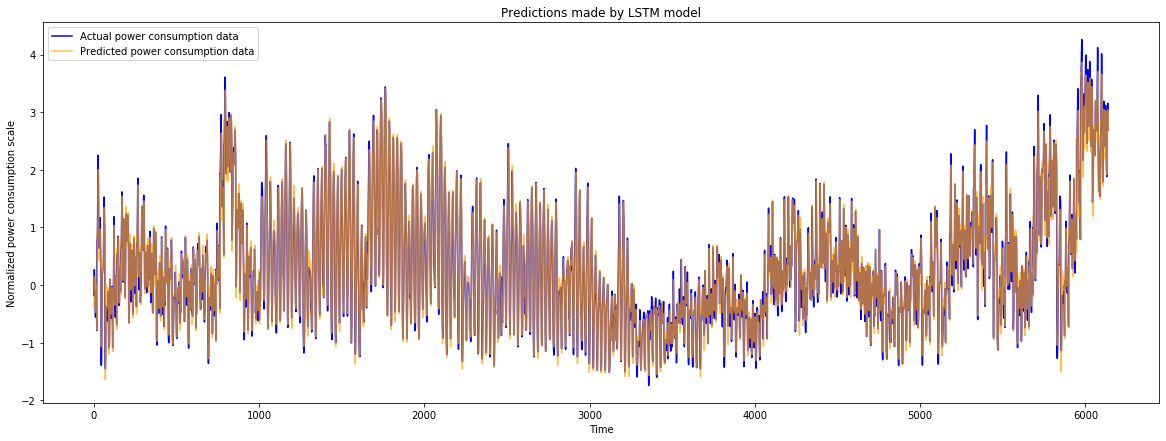

In [26]:
plot_predictions(y_test, lstm_predictions, "Predictions made by LSTM model")

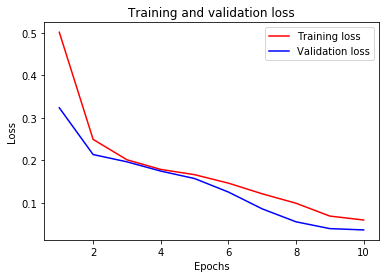

In [27]:
import matplotlib.pyplot as plt

loss = hist_2.history['loss']
val_loss = hist_2.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()